<a href="https://colab.research.google.com/github/parasgodhani01/EmotionDetection_VGG16_RESNET50/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset - kaggle directory
Kaggle - https://www.kaggle.com/datasets/msambare/fer2013

In [1]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 88% 53.0M/60.3M [00:00<00:00, 191MB/s]
100% 60.3M/60.3M [00:00<00:00, 183MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/

## Installing Packges

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

<ipython-input-4-ed049fea2f20>:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

In [10]:
from tensorflow import keras
from keras import layers,models, regularizers, optimizers
from keras.applications import VGG16,ResNet50V2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard , CSVLogger
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Activation,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.optimizers import Adam,Adamax
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array

## Setting Directory to save Model

In [11]:
os.makedirs('test_dir',exist_ok=True)

In [12]:
project_name = "Emotion_Detection"

model_names = [
    'CNN_Scratch',
    'CNN_Augmentation',
    'VGG16',
    'ResNet50V2'
]

base_dir = '/content/'

project_dir = os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)

for each_model in model_names:
  model_dir = os.path.join(project_dir,each_model)
  os.makedirs(model_dir,exist_ok=True)

print(f"Project Directory Structure Created at :{project_dir}")

Project Directory Structure Created at :/content/Emotion_Detection


## Data Cleaning

In [16]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            file_type = imghdr.what(file_path)
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                img = cv2.imread(file_path)

        except Exception as e:
            print(f'Issue with file {file_path}. Error: {e}')
            os.remove(file_path)

## Data Analysis

In [23]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

for root, dirs, files in os.walk(data_dir):

    for file in files:
        file_path = os.path.join(root, file)

        try:
            file_type = imghdr.what(file_path)
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                img = cv2.imread(file_path)

        except Exception as e:
            print(f'Issue with file {file_path}. Error: {e}')
            os.remove(file_path)

In [34]:
# this function is to count the total images for train and test for each class
def count_files_in_subdirs(directory,set_name):
  counts ={}

  for item in os.listdir(directory):
    item_path = os.path.join(directory,item)
    if os.path.isdir(item_path):
      counts[item]= len(os.listdir(item_path))
  df = pd.DataFrame(counts,index=[set_name])
  return df

train_df = '/content/train'
test_df = '/content/test'

train_count = count_files_in_subdirs(train_df,'train')
test_count = count_files_in_subdirs(test_df,'test')

print(train_count)
print(test_count)

       disgust  surprise   sad  happy  fear  neutral  angry
train      436      3171  4830   7215  4097     4965   3995
      disgust  surprise   sad  happy  fear  neutral  angry
test      111       831  1247   1774  1024     1233    958


<Axes: >

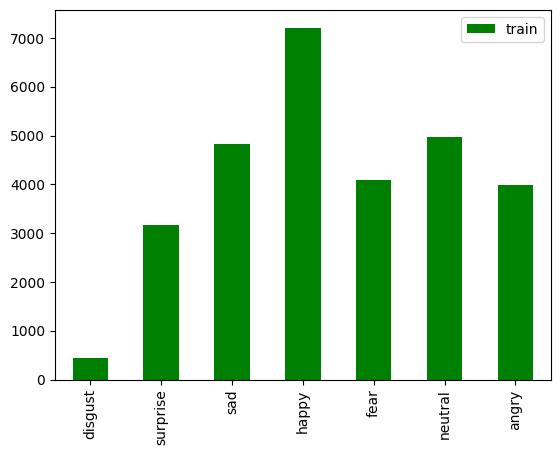

In [31]:
train_count.transpose().plot(kind='bar', color='green')

<Axes: >

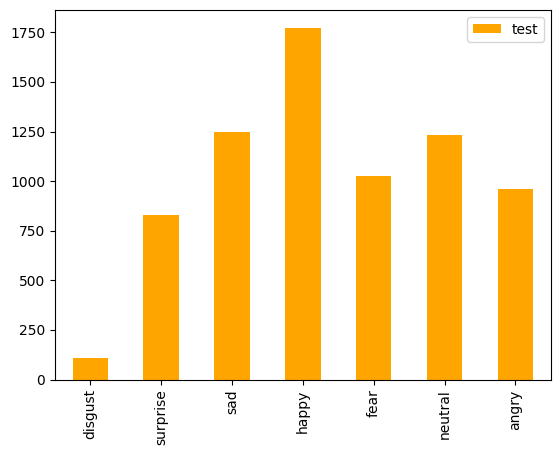

In [29]:
test_count.transpose().plot(kind='bar', color='orange')

## Plotting one image for each emotion

In [36]:
emotions = os.listdir(train_dir)
print(emotions)

['disgust', 'surprise', 'sad', 'happy', 'fear', 'neutral', 'angry']


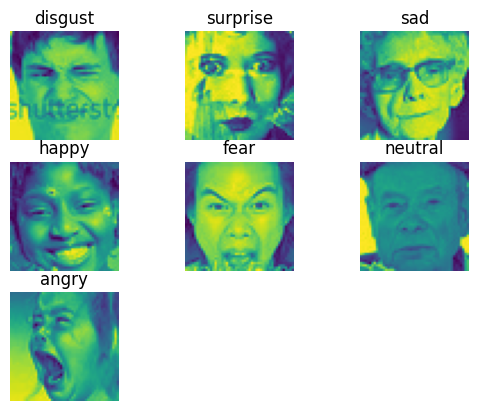

In [46]:
for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[5])
    img = plt.imread(img_path)
    plt.subplot(3,3, i)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')

## Plotting random images from given directory

In [53]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    image_filenames = os.listdir(directory_path)

    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3,3, figsize=(5, 5))
    axes = axes.ravel()   #2D t0 1D

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

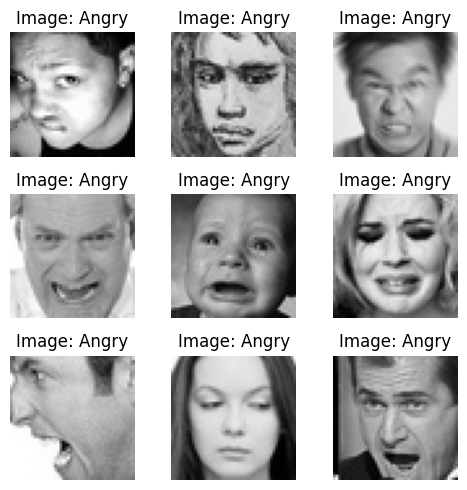

In [54]:
angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

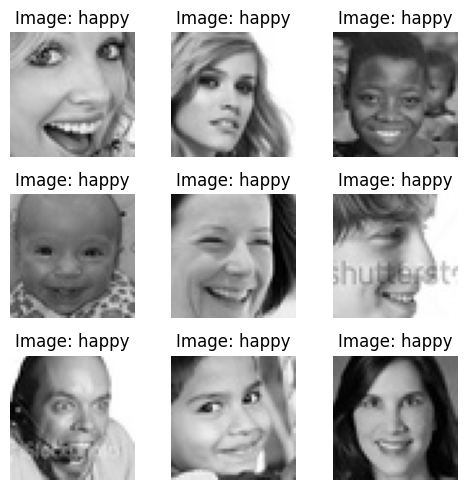

In [59]:
angry_directory_path = '/content/train/happy'
plot_images_from_directory(angry_directory_path, class_name = 'happy')

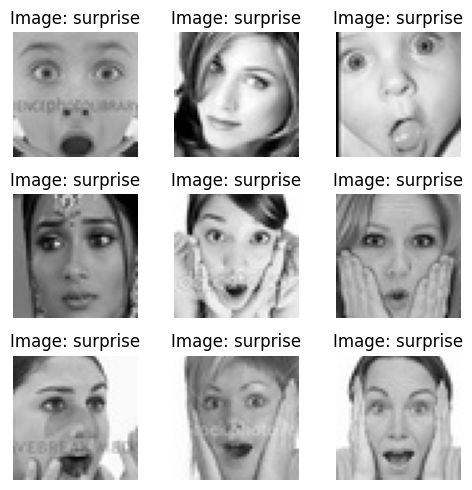

In [62]:
angry_directory_path = '/content/train/surprise'
plot_images_from_directory(angry_directory_path, class_name = 'surprise')